In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import pickle
from sklearn.metrics import *
import pandas as pd
import seaborn as sns
import statsmodels
from all_models import *

In [2]:
curvatures_smooth = pickle.load(open('curvatures_smooth_all.pickle', 'rb'))

In [3]:
fits_single = pickle.load(open('fit_single_CV_640_bestfit_starting_point.pickle', 'rb'))
fits_dual = pickle.load(open('fit_dual_CV_640_bestfit_starting_point.pickle', 'rb'))

In [4]:
single_win = np.zeros((100, 64))
for i in range(100):
    for participant in range(64):
        single_win[i][participant] =  np.around(fits_single[i][participant, -3], 0) < np.around(fits_dual[i][participant, -3], 0)

In [5]:
np.where(np.sum(single_win, axis = 0) < 41)

(array([ 0,  2,  3,  4,  6,  8, 10, 11, 12, 14, 16, 18, 21, 22, 23, 24, 26,
        28, 30, 31, 32, 33, 34, 36, 38, 39, 40, 42, 43, 44, 45, 46, 50, 51,
        53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int64),)

In [6]:
l = list()
for j in range (100):
    for i in np.where(np.sum(single_win, axis = 0) > 59)[0]:
        l.append((fits_single[j][i][-3] - fits_dual[j][i][-3]) / fits_single[j][i][-3])

In [7]:
max(l)

0.6833744599249506

# Generating Train-Test splits

In [8]:
model_errors_single = np.zeros((100, 64, 640))
model_errors_dual = np.zeros((100, 64, 640))

for i in range(100):
    for participant in range(60):
        if participant%2 == 0:
            model_errors_single[i][participant] = model_sudden(640, A=fits_single[i][participant][0], B = fits_single[i][participant][1])[0]
            model_errors_dual[i][participant] = dual_model_sudden(640, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
            
        else:
            model_errors_single[i][participant] = model_gradual(640, A=fits_single[i][participant][0], B = fits_single[i][participant][1])[0]
            model_errors_dual[i][participant] = dual_model_gradual(640, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]


In [9]:
single_train_neg2ll = np.zeros((100, 64))
single_test_neg2ll = np.zeros((100, 64))
dual_train_neg2ll = np.zeros((100, 64))
dual_test_neg2ll = np.zeros((100, 64))

for i in range(100):
    for participant in range(64):
        total_neg2ll = -2*stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:-1]), model_errors_single[i][participant], fits_single[i][participant][-2])
        single_train_neg2ll[i][participant] = sum(np.take(total_neg2ll, fits_single[i][participant][-1][fits_single[i][participant][-1] < 640]))
        single_test_neg2ll[i][participant] = sum(total_neg2ll) - single_train_neg2ll[i][participant]

        total_neg2ll = -2*stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:-1]), model_errors_dual[i][participant], fits_dual[i][participant][-2])
        dual_train_neg2ll[i][participant] = sum(np.take(total_neg2ll, fits_dual[i][participant][-1][fits_dual[i][participant][-1] < 640]))
        dual_test_neg2ll[i][participant] = sum(total_neg2ll) - dual_train_neg2ll[i][participant]
        

In [84]:
fits_single_c = np.vstack(fits_single).reshape((100, 64, 5))

In [32]:
fits_dual_c = np.vstack(fits_dual).reshape((100, 64, 7))


(100, 64, 7)

In [85]:
mean_Af = np.mean(fits_dual_c[:, :, 0], axis = 0)
mean_Bf = np.mean(fits_dual_c[:, :, 1], axis = 0)
mean_As = np.mean(fits_dual_c[:, :, 2], axis = 0)
mean_Bs = np.mean(fits_dual_c[:, :, 3], axis = 0)
mean_A = np.mean(fits_single_c[:, :, 0], axis = 0)
mean_B = np.mean(fits_single_c[:, :, 0], axis = 0)

In [82]:
dual_selected = sum(dual_test_neg2ll < single_test_neg2ll) > 59

In [87]:
mean_params = pd.DataFrame({'participant_id': np.arange(64),
                            'rotation': np.tile(['Sudden', 'Gradual'], 32),
                            'emphasis': np.repeat(['Accuracy', 'Speed'], 32),
                            'dual_selected': dual_selected,
                            'Af': mean_Af,
                            'Bf': mean_Bf,
                            'As': mean_As,
                            'Bs': mean_Bs,   
                            'A':  mean_A,
                            'B': mean_B
                           })

In [88]:
mean_params_melt = mean_params.melt(id_vars=['participant_id', 'rotation', 'emphasis','dual_selected'], value_name='param_values', var_name='params')

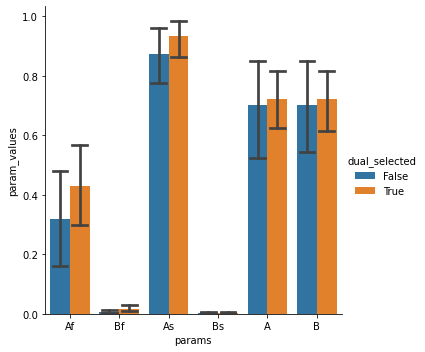

In [89]:
sns.catplot(x = 'params', y = 'param_values', hue = 'dual_selected', 
            kind = 'bar', capsize = 0.3,            
            data = mean_params_melt)

In [34]:
sum(np.sum(dual_test_neg2ll[:, 1:32:2] < single_test_neg2ll[:, 1:32:2], axis = 0) > 59)

11

In [220]:
group = 3
sum(sum(dual_train_neg2ll[:, group::4] < single_train_neg2ll[:, group::4]) > 59)

11

In [22]:
np.where(np.sum(dual_test_neg2ll < single_test_neg2ll, axis = 0) > 59)[0]

array([ 1,  3,  4,  5,  6,  8,  9, 10, 13, 14, 17, 18, 19, 21, 22, 23, 24,
       25, 26, 29, 30, 33, 34, 35, 36, 37, 38, 40, 41, 42, 44, 45, 46, 49,
       50, 53, 54, 55, 56, 57, 58])

In [61]:
dual_test_neg2ll[4]  single_test_neg2ll[4]

In [263]:
for i in np.where(np.sum(dual_test_neg2ll < single_test_neg2ll, axis = 0) < 59)[0]:
    for j in range(100):
        l.append((single_test_neg2ll[j][i] - dual_test_neg2ll[j][i]))

(array([5.200e+01, 1.110e+03, 3.324e+03, 1.740e+02, 1.080e+02, 2.400e+01,
        4.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([-1.00132642, -0.54874609, -0.09616575,  0.35641458,  0.80899492,
         1.26157525,  1.71415558,  2.16673592,  2.61931625,  3.07189658,
         3.52447692]),
 <BarContainer object of 10 artists>)

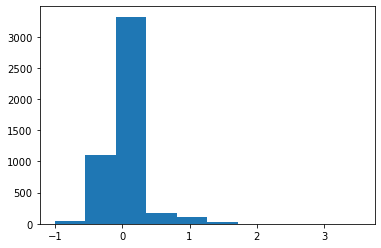

In [264]:
plt.hist(l)